In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load dataset
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

print(ds_info)


tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Preprocessing function for MobileNetV2
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Apply preprocessing
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Check one batch
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [4]:
from tensorflow.keras.applications import MobileNetV2

# Load pretrained MobileNetV2
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,   # remove ImageNet classifier
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False

# Check model
base_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
from tensorflow.keras import layers, models

# Number of flower classes
NUM_CLASSES = 5

# Build the model
model = models.Sequential([
    base_model,                              # frozen MobileNetV2
    layers.GlobalAveragePooling2D(),         # reduces feature maps
    layers.BatchNormalization(),             # stabilizes training
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),                     # prevents overfitting
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Show model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,717 (9.26 MB)

 Trainable params: 167,173 (653.02 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully ")


Model compiled successfully 


In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.6397 - loss: 1.0662 - val_accuracy: 0.8978 - val_loss: 0.3235
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8733 - loss: 0.3705 - val_accuracy: 0.9114 - val_loss: 0.2587
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9131 - loss: 0.2366 - val_accuracy: 0.9005 - val_loss: 0.2477
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9282 - loss: 0.2006 - val_accuracy: 0.9074 - val_loss: 0.2529
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9440 - loss: 0.1507 - val_accuracy: 0.9155 - val_loss: 0.2342
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9557 - loss: 0.1332 - val_accuracy: 0.9101 - val_loss: 0.2482
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9647 - loss: 0.1138 - val_accuracy: 0.9060 - val_loss: 0.2516
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9635 - loss: 0.0917 - val_accuracy: 0.9114 - v

In [11]:
# Unfreeze the top layers of MobileNetV2
base_model.trainable = True

# Freeze bottom layers, unfreeze top 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False


In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
fine_tune_epochs = 8

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[early_stop]
)


Epoch 1/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.8744 - loss: 0.3621 - val_accuracy: 0.9046 - val_loss: 0.2633
Epoch 2/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.8990 - loss: 0.2923 - val_accuracy: 0.9019 - val_loss: 0.2778
Epoch 3/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9268 - loss: 0.2103 - val_accuracy: 0.9060 - val_loss: 0.2861
Epoch 4/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9364 - loss: 0.2106 - val_accuracy: 0.9114 - val_loss: 0.2777


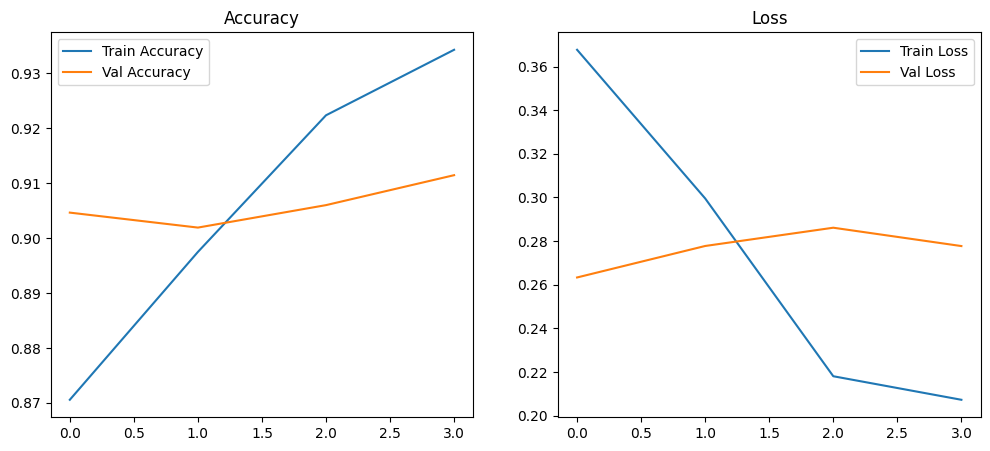

In [15]:
import matplotlib.pyplot as plt

acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [16]:
# Final training and validation accuracy
train_acc = history_fine.history['accuracy'][-1]
val_acc = history_fine.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")


Final Training Accuracy: 0.9343
Final Validation Accuracy: 0.9114


In [23]:
# Save the model
model.save("my_model.h5")
print("Model saved as my_model.h5")


Model saved as my_model.h5


In [26]:
from google.colab import files

# Make sure the model is saved first
model.save("my_model.h5")

# Download the file
files.download("my_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>